<a href="https://colab.research.google.com/github/iciromaco/Semi3A/blob/master/L8/CardCapture0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
from math import *
from time import time

# ORB特徴検出器
# orb = cv2.ORB_create(50) # 50点を上限とする 

# AKAZE特徴検出器
akaze = cv2.AKAZE_create()  

# 年賀状フリー素材 https://www.bing.com/images/search?q=%e7%8c%aa%e9%b9%bf%e8%9d%b6+%e5%b9%b4%e8%b3%80%e7%8a%b6+%e3%83%95%e3%83%aa%e3%83%bc%e7%b4%a0%e6%9d%90&FORM=HDRSC2
# カードの特徴をあらかじめ検出しておく
cardfilename = ["ar0.png","ar1.png","ar2.png","ar3.png","ar4.png","ar5.png","hd1.jpg","hd2.jpg","hd3.jpg","hd4.jpg"]
ncards = len(cardfilename) # 認識対象カード数
class card:
    def __init__(self,filename):
        self.col = cv2.imread(filename,1)
        img = cv2.imread(filename,0)
        self.gry = cv2.GaussianBlur(img,(13,13),0)        # ガウスフィルタでぼかす
        # 画像のサイズ
        self.h,self.w,_ = self.col.shape
        # ORB特徴
        # (self.kps, self.des) = orb.detectAndCompute(self.gry,None)
        (self.kps, self.des) = akaze.detectAndCompute(self.gry,None)
        print("{}  特徴数 {}".format(filename,len(self.kps)))

cardDB = [None]*ncards
MaxCheight = MaxCwidth = 0 # 一番大きい画像のサイズ
for i,f in enumerate(cardfilename):
  cardDB[i] = thecard = card(f) # カードの登録
  if thecard.h > MaxCheight:
    MaxCheight = thecard.h
  if thecard.w > MaxCwidth:
    MaxCwidth = thecard.w

ar0.png  特徴数 72
ar1.png  特徴数 55
ar2.png  特徴数 21
ar3.png  特徴数 45
ar4.png  特徴数 29
ar5.png  特徴数 56
hd1.jpg  特徴数 190
hd2.jpg  特徴数 283
hd3.jpg  特徴数 172
hd4.jpg  特徴数 236


# AKAZE特徴の例


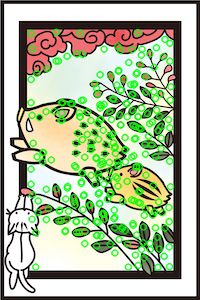

In [2]:
from google.colab.patches import cv2_imshow
img = cardDB[7].col
outimg = np.zeros_like(img)
kps = cardDB[7].kps
cv2.drawKeypoints(img,kps,outimg,color=(0,255,0), flags=0)
cv2_imshow(outimg)

# Keypoints

In [3]:
len(kps) # 特徴数

283

In [4]:
kps[0].pt # 特徴の座標

(56.00910568237305, 31.67071533203125)

In [5]:
kps[0].size # サイズ

4.800000190734863

In [6]:
kps[0].angle # 基準方向の角度

88.6507797241211

# Description

In [7]:
desc1 = cardDB[7].des
desc1

array([[255,   2, 254, ...,  97, 204,  62],
       [ 39,   8, 254, ..., 135,   0,  55],
       [ 62,   6, 246, ..., 223,  11,  52],
       ...,
       [101, 249,   8, ..., 255, 191,  37],
       [ 72, 249,   3, ..., 253, 175,  55],
       [247,   1, 248, ..., 105, 255,  62]], dtype=uint8)

# BFMatching （総当たり法）

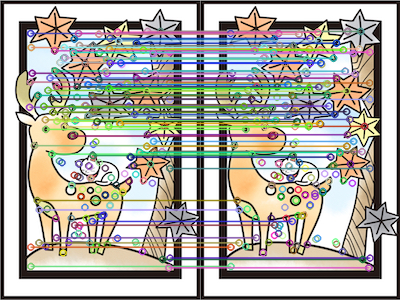

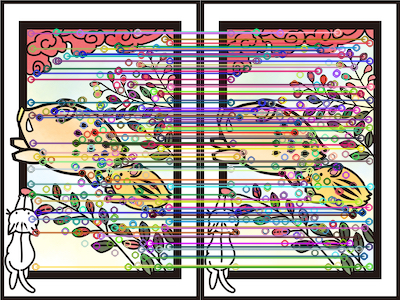

In [8]:
#bf = cv2.BFMatcher(cv2.NORM_HAMMING) # ORBの場合
bf = cv2.BFMatcher()
def showmatch(i,j):
  img = cardDB[i].col
  kps = cardDB[i].kps
  des = cardDB[i].des
  img2 = cardDB[j].col
  kps2 = cardDB[j].kps
  des2 = cardDB[j].des
  matches = bf.match(des, des2)
  img3 = cv2.drawMatches(img, kps, img2, kps2, matches[:100], None)
  cv2_imshow(img3)

showmatch(6,6)
showmatch(7,7)


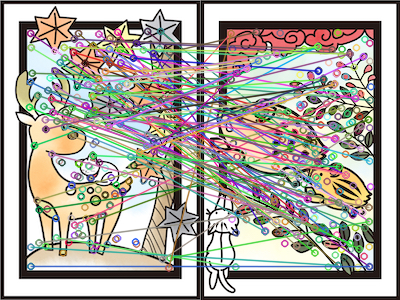

In [9]:
showmatch(6,7)

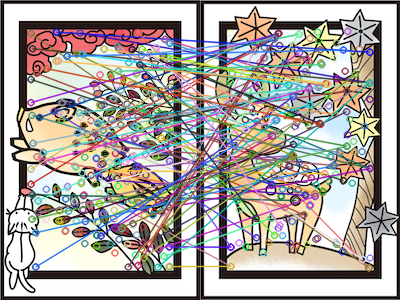

In [10]:
showmatch(7,6)

全然違う絵でも、それぞれの特徴に一番近い特徴というのは必ずあるので、どこかにマッチする。


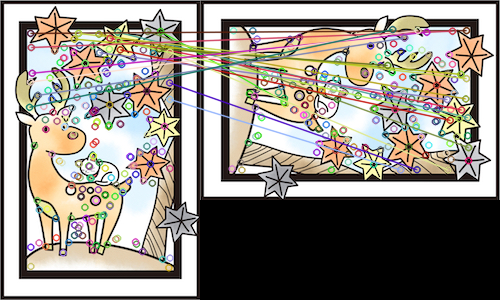

In [11]:
img=cardDB[6].col
kps = cardDB[6].kps
des = cardDB[6].des
imgT = img.transpose(1,0,2)[:,::-1]
gryT = cv2.GaussianBlur(imgT,(13,13),0)        # ガウスフィルタでぼかす
#(kpsT, desT) = orb.detectAndCompute(gryT,None)
(kpsT, desT) = akaze.detectAndCompute(gryT,None)
matches = bf.match(des, desT)
img3 = cv2.drawMatches(img, kps, imgT, kpsT, matches[:20], None) # 20点だけ結ぶ
cv2_imshow(img3)

# ANN近似最近傍探索＋K-nn
NN（近傍探索）は、近傍から順にサーチすること。しかし、多次元なので厳密な意味で近い順にサーチするのは無理である。それができるなら、探索する必要がない。

ANNは近似近傍探索。たとえば、全部の軸ではなく、いくつかの軸を選んでハッシュして並べたり、近い順に検索ツリーを形成しておく。

K-nnは、最も近い１つではなく、近い順にK個選びだすこと

In [0]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
# ORBの場合
#FLANN_INDEX_LSH = 6
#index_params= dict(algorithm = FLANN_INDEX_LSH,
#                   table_number = 6, # 12
#                   key_size = 12,     # 20
#                   multi_probe_level = 1) #2
flann = cv2.FlannBasedMatcher(index_params,search_params)

In [13]:
scenefile = "scene.jpg"
scene = cv2.imread(scenefile)
w = scene.shape[1]//2 # 画像が大きすぎるので半分にカットしているだけ
scene = scene[:,:w]
sceneG = cv2.cvtColor(scene,cv2.COLOR_BGR2GRAY)
sceneG = cv2.GaussianBlur(sceneG,(13,13),0) 
(Skps, Sdes) = akaze.detectAndCompute(sceneG,None)
#orb = cv2.ORB_create(200) #200点を上限とする 
#(Skps, Sdes) = orb.detectAndCompute(sceneG,None)
print("{}  特徴数 {}".format(scenefile,len(Skps)))

scene.jpg  特徴数 2582


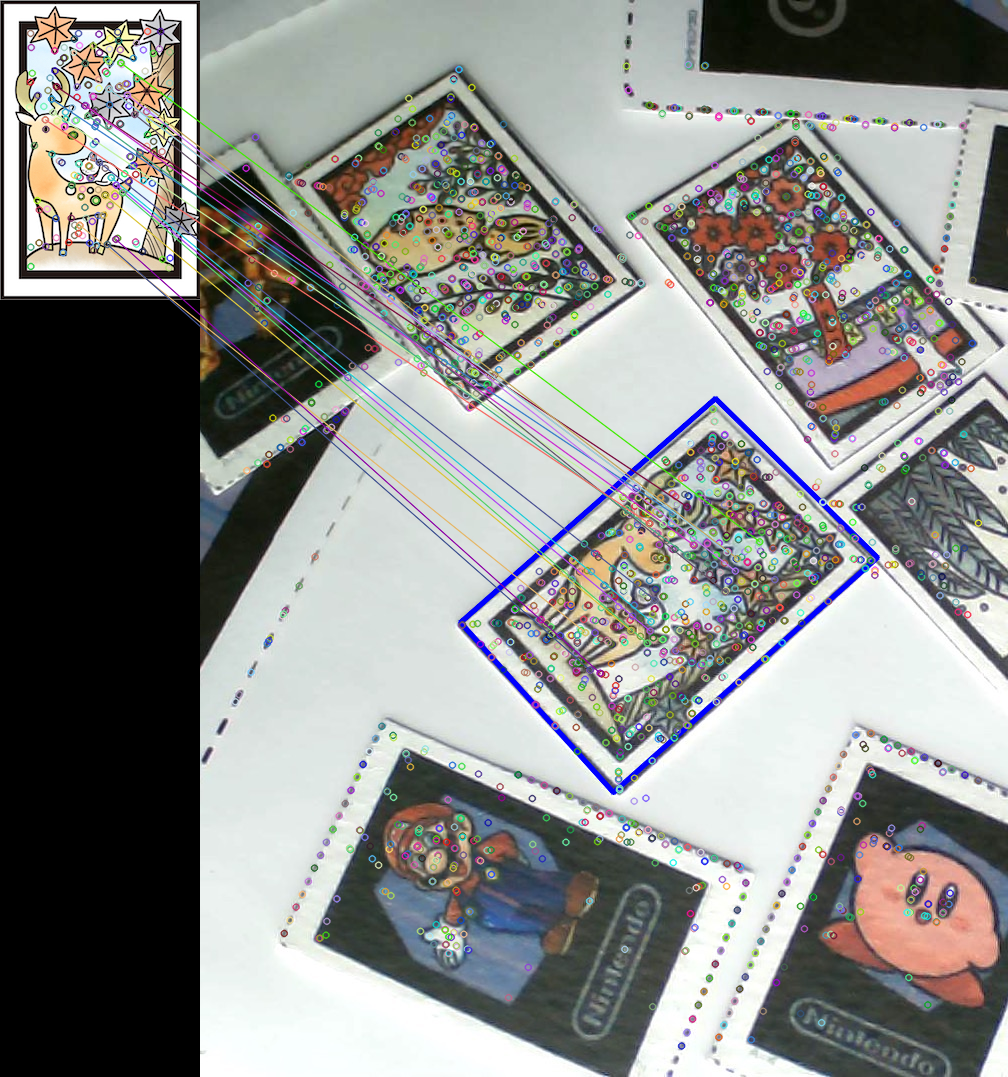

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]


In [14]:
MIN_MATCH_COUNT = 5 # これより少ない照合しかできないときは枠線を描かない。
def smatch(i,simg):
  kp1 = cardDB[i].kps
  des1 = cardDB[i].des
  des1 = np.float32(des1)
  sceneG = cv2.cvtColor(simg,cv2.COLOR_BGR2GRAY)
  sceneG = cv2.GaussianBlur(sceneG,(13,13),0) 
  (kp2, des2) = akaze.detectAndCompute(sceneG,None)
  des2 = np.float32(des2)
  matches = flann.knnMatch(des1,des2,k=2)
  good = []
  for ms in matches:
    if len(ms) == 2:
      m,n = ms
      # print(m.distance,n.distance)
      if m.distance < 0.8*n.distance: # 2番目に近いものより距離が0.9未満であるマッチングを残す
        good.append(m)
  if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0) # 変換行列
    matchesMask = mask.ravel().tolist()

    h,w = cardDB[i].gry.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(simg.copy(),[np.int32(dst)],True,255,3, cv2.LINE_AA)
    img3 = cv2.drawMatches(cardDB[i].col, cardDB[i].kps, img2, kp2, good[:20], None)
    cv2_imshow(img3)  
  else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None
  print(matchesMask)
  
smatch(6,scene)

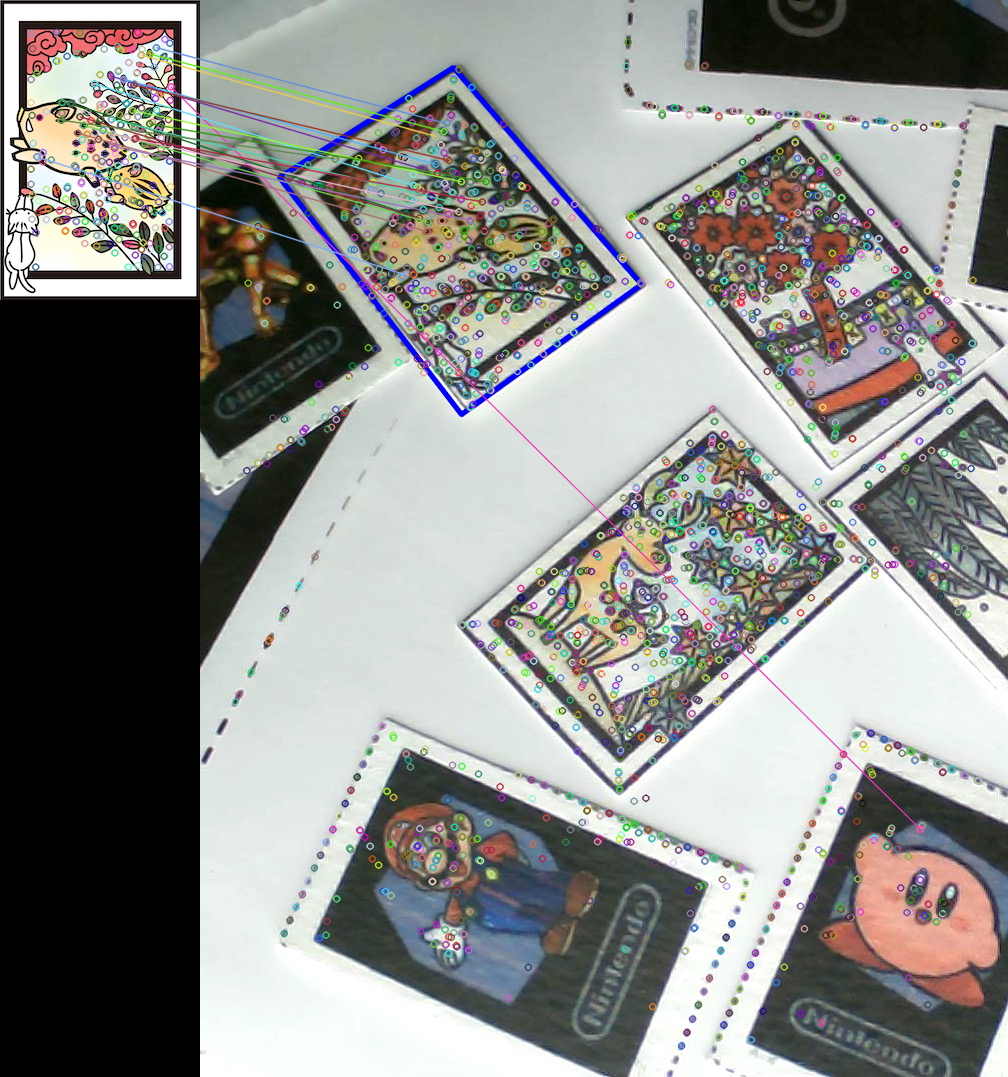

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [15]:
smatch(7,scene)

In [16]:
smatch(8,scene)

Not enough matches are found - 2/5
None


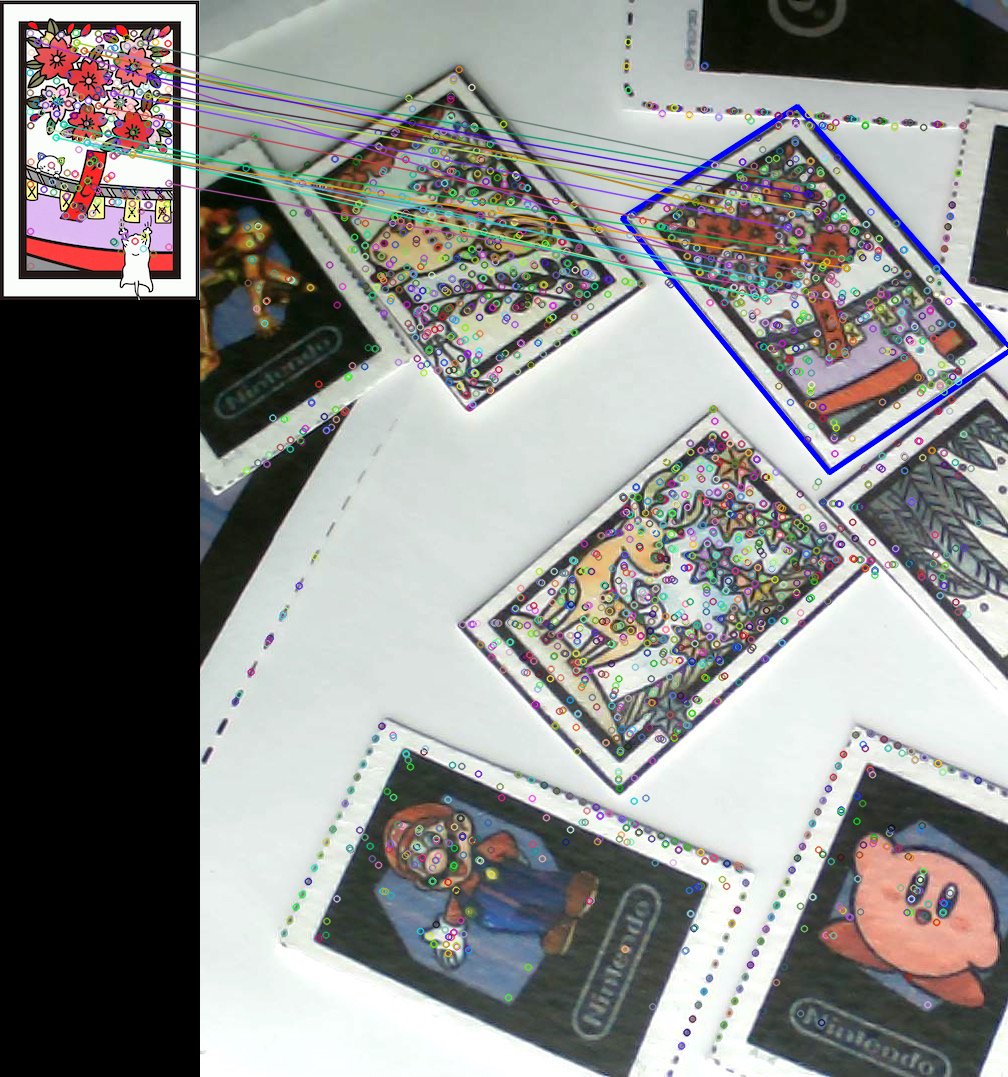

[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [17]:
smatch(9,scene)

# 中央付近を切り出してもっともマッチするものを見つける

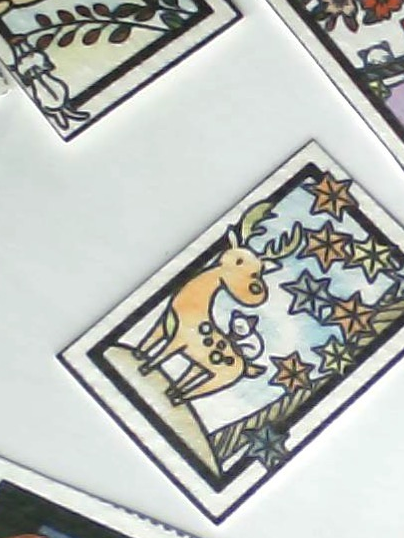

In [18]:
h,w = scene.shape[:2]
h2 = h//2
w2 = w//2
x0 = w2//2
y0 = h2//2
cimg = scene[y0:y0+h2,x0:x0+w2]
cv2_imshow(cimg)
sceneG = cv2.cvtColor(cimg,cv2.COLOR_BGR2GRAY)
sceneG = cv2.GaussianBlur(sceneG,(13,13),0) 
(kps2, des2) = akaze.detectAndCompute(sceneG,None)


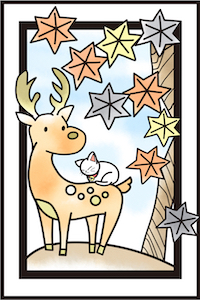

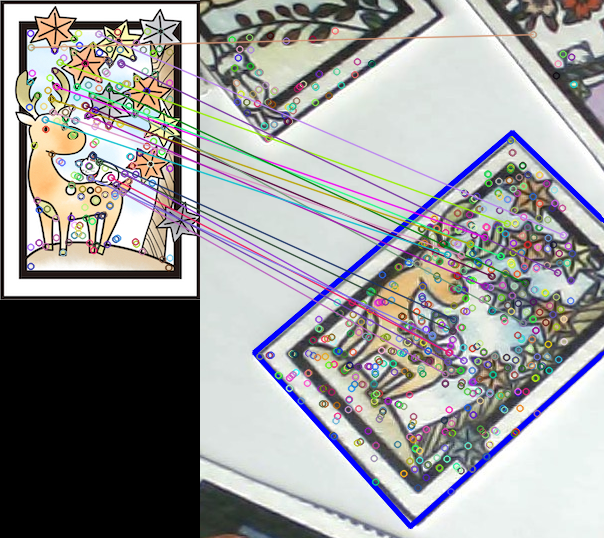

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]


In [19]:
FOUNDTH = 10
BIGNUMBER = 1e6 # 1000000 （大きい数値）

# bestmatch 最もマッチするカード番号
# valmin 対応特徴間の平均距離の最小値
# bestpairs 最もマッチしたカードのマッチング情報
DISTANCETHRES=1024.0 # これ以上距離がある場合は候補から外す。AKAZEは61次元 で各255までで表されている

bestmatch,valmin,bestpairs = -1,BIGNUMBER,[] 

des2 = np.float32(des2) # AKAZE特徴は float32でないとエラーが出る

good = [None]*len(cardDB)
for index,card in enumerate(cardDB):
  des1 = card.des
  des1 = np.float32(des1)
  kps1 = card.kps
  
  matches = flann.knnMatch(des1,des2,k=2) # 各特徴に近い特徴を第2候補まで選ぶ
  good[index] = []
  for ms in matches:
    if len(ms) ==  2: # 必ずしも第2候補まで見つかるとは限らない
      m,n = ms
      if m.distance < DISTANCETHRES and m.distance < 0.8*n.distance: # 2番目に近いものより距離が0.9未満であるマッチングを残す
        good[index].append(m)

bestmatch,valmin = -1,BIGNUMBER
for index in range(len(cardDB)):
  dd = np.sort([m.distance for m in good[index]])[:10]
  if len(dd) > 0 and np.sum(dd)/len(dd) < valmin:
    bestmatch = index  
    valmin = np.sum(dd)/len(dd)
cv2_imshow(cardDB[bestmatch].col)
smatch(bestmatch,cimg)